In [1]:
%matplotlib notebook
from IPython.display import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [2]:
import h5py
import torch
import numpy as np

from sklearn import decomposition

from orthonet import jacob

## Quickly check out data

<IPython.core.display.Javascript object>


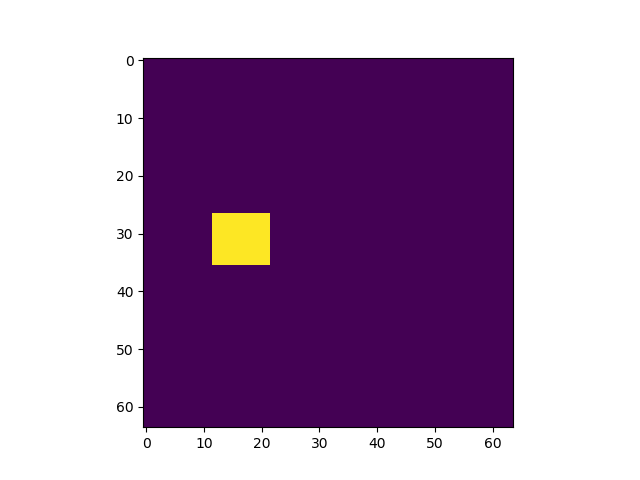

[[0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 2]]
[[1.         1.         0.5        0.         0.         0.        ]
 [1.         1.         0.5        0.         0.         0.03225806]
 [1.         1.         0.5        0.         0.         0.06451613]]


In [15]:
BASE_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/sprites/'

df = h5py.File(BASE_PATH + 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.hdf5', 'r')
original_data = np.array(df['imgs'][:1028])
classes = np.array(df['latents/classes'])
values  = np.array(df['latents/values'])
df.close()

plt.figure()
plt.imshow(original_data[47])
plt.show()

print(classes[:3])
print(values[:3])

### Load Data & Model

In [17]:
def load_model(model_path, original_data):

    model = torch.load(model_path + '/model.pt')

    ot = torch.tensor(original_data.astype(np.float32))
    latent = model.encode(ot).detach().numpy()
    recon  = model(ot)

    # deals with VAE case where I also saved logvar, use only mu here
    if type(recon) == tuple:
        recon = recon[0].detach().numpy()
    else:
        recon = recon.detach().numpy()

    return model, latent, recon

MODEL_PATH = BASE_PATH + 'ortho_spritesvae-1.00e+00_ob1.00e+00_db1.00e+00'
model, latent, recon = load_model(MODEL_PATH, original_data)

### Take a look at the training curves and direct latent space

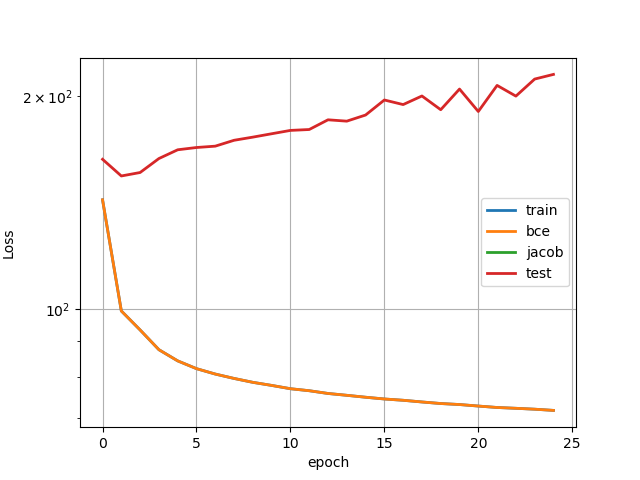

In [18]:
Image(filename=MODEL_PATH + '/loss_curves.png')

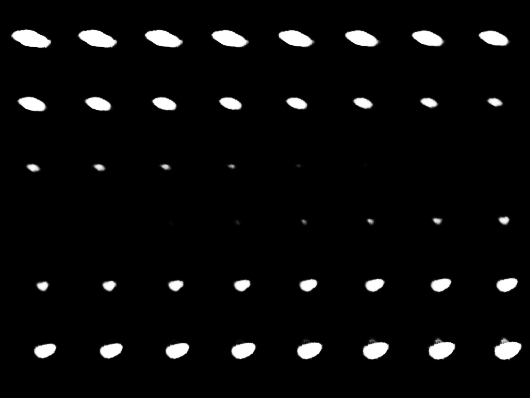

In [19]:
Image(filename=MODEL_PATH + '/z0.png')

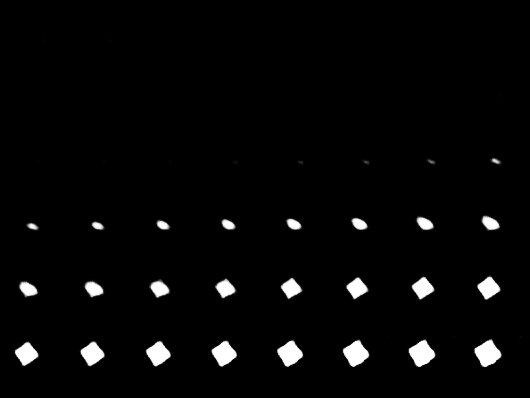

In [20]:
Image(filename=MODEL_PATH + '/z1.png')

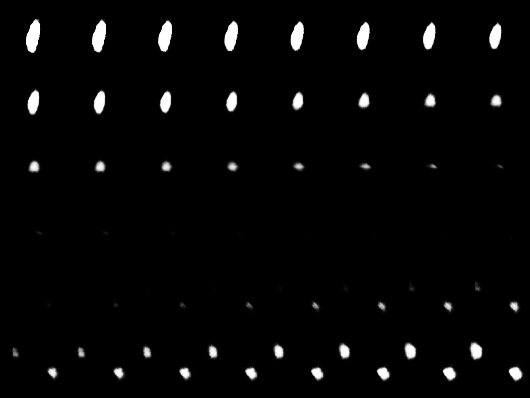

In [21]:
Image(filename=MODEL_PATH + '/z2.png')

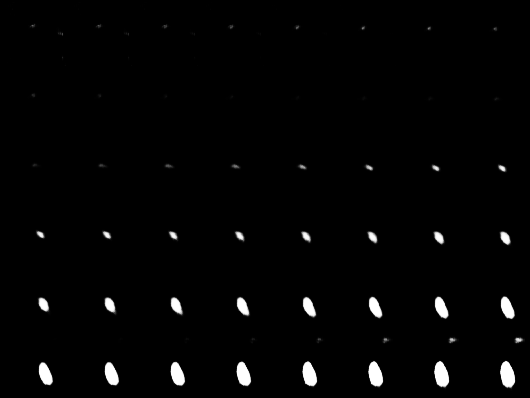

In [22]:
Image(filename=MODEL_PATH + '/z3.png')

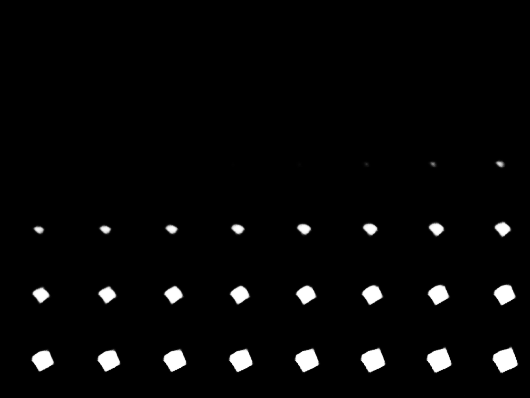

In [23]:
Image(filename=MODEL_PATH + '/z4.png')

### PCA Analysis of Latent Space

<IPython.core.display.Javascript object>


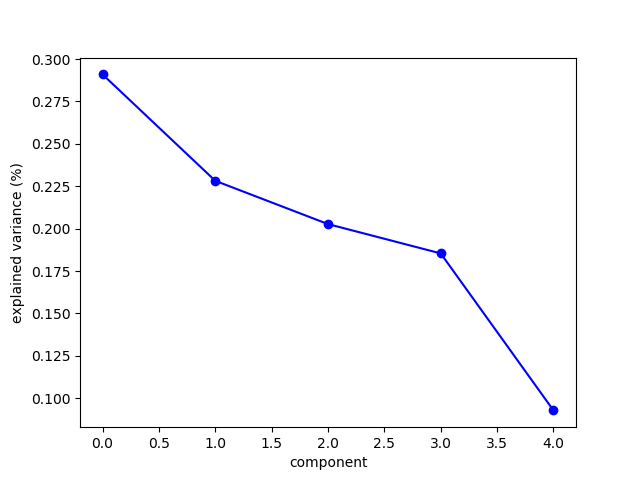

In [24]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

In [25]:
max_pts = 1280
l = 3 # plot limits

latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=r[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['radius'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])


ax = fig.add_subplot(122, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=theta[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['angle'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])

plt.savefig(MODEL_PATH+'/latent.pdf')
plt.show()

(1028, 5)


<IPython.core.display.Javascript object>

NameError: name 'r' is not defined

### Direct look at the Jacobian of the resulting network

In [83]:
n_samples = 128
n_outputs = torch.tensor(np.product(origin.shape[1:]))

J = np.zeros([1089, 5])
for i in range(n_samples):
    Jx = jacob.jacobian(model.decode, torch.tensor(latent[i]), n_outputs)
    J += Jx.detach().numpy()

<IPython.core.display.Javascript object>


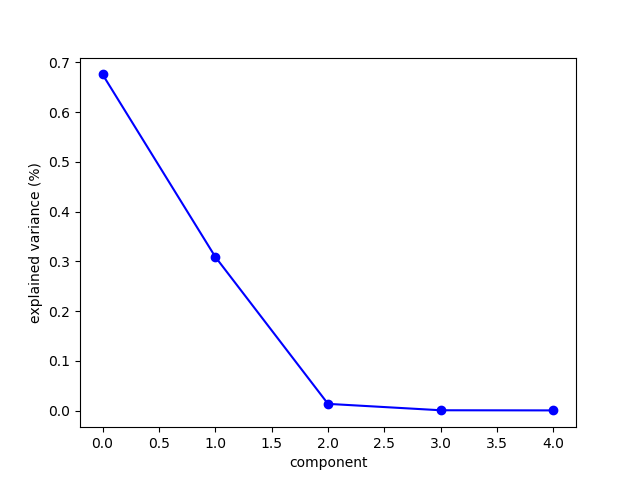

In [84]:
J_pca = decomposition.PCA(n_components=J.shape[1])
J_pca.fit(J)

plt.figure()
plt.plot(J_pca.explained_variance_ratio_, 'bo')
plt.plot(J_pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

<IPython.core.display.Javascript object>


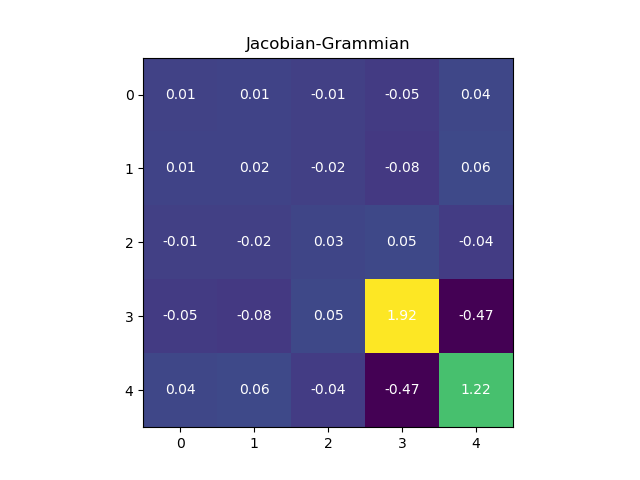

In [85]:
JG = np.dot(J.T, J)

plt.figure()
plt.title('Jacobian-Grammian')
plt.imshow(JG)

for (j,i),label in np.ndenumerate(JG):
    plt.text(i, j, np.round(label,2), ha='center', va='center', color='w')
    
plt.show()

### Investigate the effect of parameters on the dimensionality of the latent space

In [39]:
dbeta = 1.0
obetas = [10, 30, 100, 300, 1000]
vbetas = [0.1, 0.3, 1.0, 1.5, 3.0, 10.0]

variance_cutoff = 1e-2

n_dimensions = np.zeros((len(vbetas), len(obetas)))

for i,vbeta in enumerate(vbetas):
    for j,obeta in enumerate(obetas):

        model_path = BASE_PATH + 'ortho_vae-%.2e_ob%.2e_db%.2e' % (vbeta, obeta, dbeta)
        
        _, latent, _ = load_model(model_path, origin)
        n_components = latent.shape[1]

        pca = decomposition.PCA(n_components=n_components)
        pca.fit(latent)
        
        nd = np.sum(pca.explained_variance_ratio_ > variance_cutoff)
        print(obeta, vbeta, pca.explained_variance_ratio_)
        n_dimensions[i,j] = nd

10 0.1 [3.5781342e-01 2.9438165e-01 2.2157429e-01 1.2621933e-01 1.1315494e-05]
30 0.1 [4.1212013e-01 3.6157703e-01 1.6083483e-01 6.5397799e-02 7.0214352e-05]
100 0.1 [4.8606807e-01 3.2715303e-01 1.4439602e-01 4.2316973e-02 6.5892404e-05]
300 0.1 [4.8536253e-01 3.4027141e-01 1.7429674e-01 4.9951261e-05 1.9386338e-05]
1000 0.1 [4.1515225e-01 3.9199832e-01 1.8720214e-01 5.6350259e-03 1.2272731e-05]
10 0.3 [4.18096691e-01 3.52130800e-01 2.29753166e-01 1.40621705e-05
 5.23278459e-06]
30 0.3 [3.5320505e-01 3.0229950e-01 1.9612153e-01 1.4836198e-01 1.1926309e-05]
100 0.3 [5.51000953e-01 4.48761404e-01 1.60119918e-04 6.41606603e-05
 1.33352505e-05]
300 0.3 [5.2185428e-01 4.7799489e-01 1.1038796e-04 3.1084255e-05 9.3005001e-06]
1000 0.3 [5.1991564e-01 4.7993469e-01 9.9250683e-05 4.1217598e-05 9.2754517e-06]
10 1.0 [5.1102966e-01 4.8891991e-01 3.1123098e-05 1.4718790e-05 4.5603947e-06]
30 1.0 [5.6627655e-01 4.3360692e-01 1.0348605e-04 7.8084904e-06 5.1351412e-06]
100 1.0 [5.7622600e-01 4.2367184

<IPython.core.display.Javascript object>


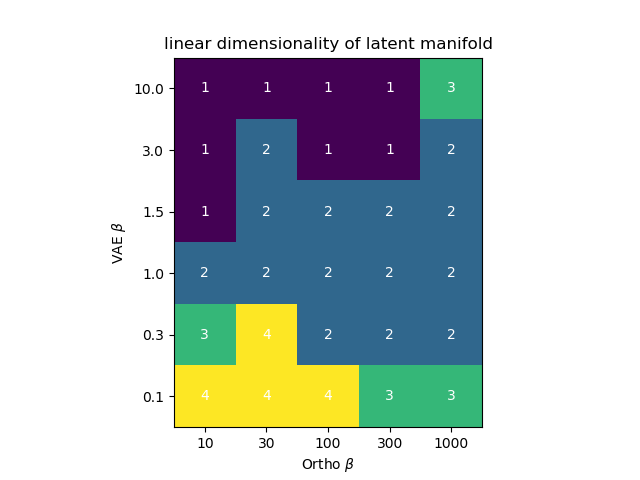

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


In [41]:
plt.figure()

plt.title('linear dimensionality of latent manifold')

ax = plt.subplot(111)
ax.imshow(n_dimensions, aspect=1, origin='bottomleft')

ax.set_yticklabels(['x'] + list(vbetas))
ax.set_xticklabels(['x'] + list(obetas))
plt.ylabel(r'VAE $\beta$')
plt.xlabel(r'Ortho $\beta$')

for (j,i),label in np.ndenumerate(n_dimensions):
    plt.text(i, j, int(label), ha='center', va='center', color='w')

plt.show()